In [1]:
%matplotlib inline
import numpy as np

import scipy
import scipy.special as special
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg

import sys
sys.path.append("src/")

import quadtree
import plotter
import fem
import geometry as geo

# Time-dependent PDEs

So far we've seen ODEs, and looked at time-integration techniques, and then PDEs but we mostly focused on stationary problems. Now we will combine the two and look at time-dependent PDEs. As a model problem we will consider the [*heat equation*](https://en.wikipedia.org/wiki/Heat_equation) which models the diffusion of heat in a material with some given thermal conductivity

$$
\partial_t u - \alpha \nabla^2 u = 0
$$

augmented with appropriate initial and boundary conditions. We will look at both implicit and explicit time integration schemes for this equation, starting with explicit schemes.

## An explicit scheme

We will first discretise the time derivative. Recall the general form of an ODE is

$$
\partial_t u = f(t, u)
$$

where here we have

$$
f(t, u) = \alpha \nabla^2 u.
$$

In an explicit scheme, we evaluate $f(u)$ at the beginning of the timestep. We'll start with explicit Euler

$$
u^{n+1} = u^n + \Delta t \alpha \nabla^2 u^n.
$$

So given an initial condition $u^0$ we just need to be able to compute $\alpha \nabla^2 u^0$ and add it on to get the value at the next timestep.

Let's solve this problem on the square domain $\Omega = [0, 1] \times [0, 1]$ with the boundary conditions

$$
\begin{aligned}
u &= 1 && x = 0, y \in [0.25, 0.75]\\
u &= 0 && x = 1, y \in [0.6, 0.8]\\
\nabla u \cdot n &= 0 && \text{otherwise}.
\end{aligned}
$$

We can think of this as modelling a 2D room with a radiator on one wall, a window on the other, and perfectly insulating (ha!) walls everywhere else.

In [2]:
def is_dirichlet(vertex):
    if vertex[0] > 1.0-1e-8 and 0.25<=vertex[1]<=0.75:
        return True
    if vertex[0] < 1e-8 and 0.6<=vertex[1]<=0.8:
        return True
    return False

def dirichlet_val(vertex,hx,hy):
    if vertex[0] < hx:
        return 1.0
    return 0.0

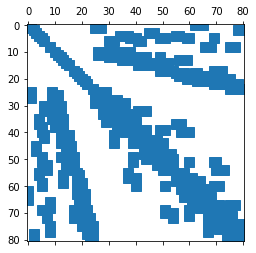

In [3]:
level = 3
geometry = geo.Geometry(5,is_dirichlet)
discretization = fem.Discretization(geometry,level=level,eval_k=lambda x,y: 1)
stiffness = discretization.setup_stiffness(True)

#print(stiffness.todense())

import matplotlib.pylab as plt
plt.spy(stiffness)

Now we're ready to integrate the equation, let's try on a relatively coarse grid.;

In [71]:
def f(u):
    f_ = - stiffness @ u
    for cell in geometry.grid.dfs(discretization.level):
        for lin, vertex in enumerate(cell.vertices):
            if vertex in discretization.cur_dirichlet_vertices:
                # Dirichlet vertices not contained in update
                f_[vertex] = 0.0
    return f_

def explicit_euler(u0, dt, T=500):
    us = [u0]
    ts = [0]
    update = np.zeros_like(u0)
    import copy
    u = copy.copy(u0)
    t = 0 
    while t < T:
        update = f(u)
        if np.linalg.norm(update, np.inf) < 1e-8:
            print("Equilibrium reached at t=",t)
            # Terminate if we've reached a steady-state
            break
        # Explicit Euler: u <- u + dt f(u)
        u += dt*update
        us.append(u)
        t += dt
        ts.append(t)
    return ts, us

In [72]:
dt = 0.13
u0 = discretization.setup_initial()
ts, us = explicit_euler(u0, dt, T=10.0)

0.0
1.0


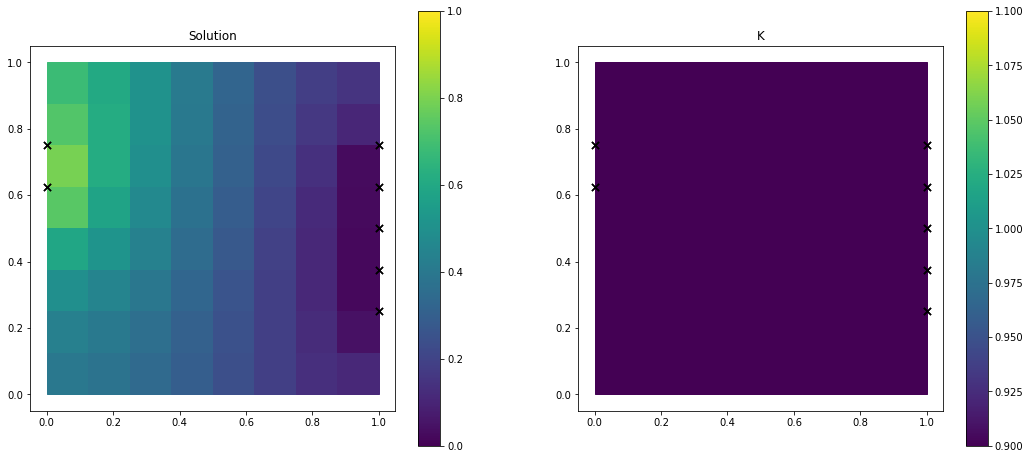

In [73]:
print(min(us[-1]))
print(max(us[-1]))

geo.plot_solution(geometry=geometry, discretization=discretization, dirichlet_val=dirichlet_val, sol=us[-1], level=level)

This looks like the solution I'm expecting, but the timestep is *very* small. Let's see what happens when we make the timestep bigger.

In [7]:
dt = 0.14
u0 = discretization.setup_initial()
ts, us = explicit_euler(u0, dt, T=10.0)

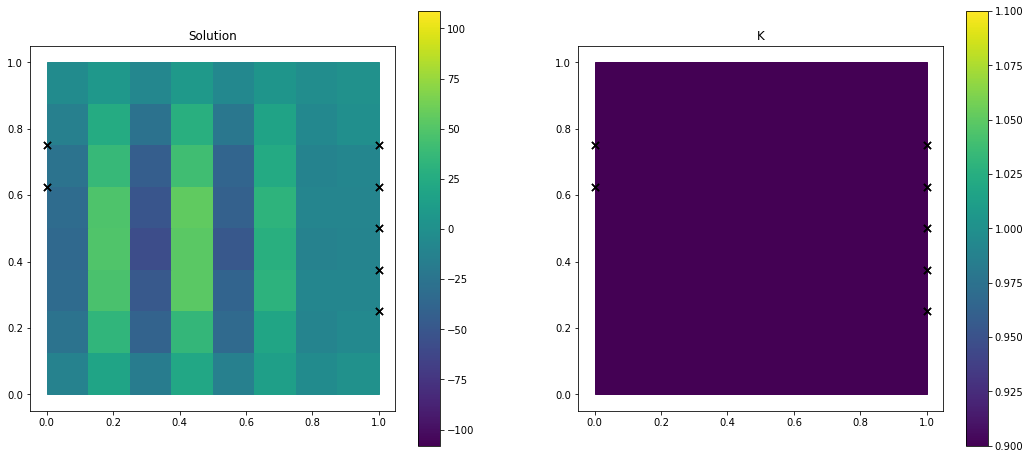

In [8]:
geo.plot_solution(geometry=geometry, discretization=discretization, dirichlet_val=dirichlet_val, sol=us[-1], level=level)

## Instability for large timesteps

Uh-oh, this looks bad. What's going on? We have hit the [CFL](https://en.wikipedia.org/wiki/Courant–Friedrichs–Lewy_condition) constraint for this PDE.

This property of a timestepping scheme, named after three mathematicians, Courant, Friedrichs, and Lewy, provides us with a rule for determining an appropriate maximum timestep given a particular spatial discretisation. An intuition for what is going on is that the *physical* equation has some domain of dependence. A region of the solution at time $t$ affects some other region of the solution at $t + \Delta t$. If our numerical scheme fails to capture this dependence, we get bad behaviour.

In other words, if we pick a timestep that is too large, information can propagate "too fast" in our numerical simulation.

The CFL condition was developed in the analysis of advection equations

$$
\partial_t u - w \cdot \nabla u = 0.
$$

For which we have the constraint (with $w = 1$)

$$
\frac{\Delta t}{\Delta x} \le 1.
$$

That is, I can't push information more than a single cell in one timestep.

For the heat equation, the restriction is much tighter, we need

$$
\frac{\Delta t}{(\Delta x)^2} \le c
$$

with $c$ some (dimension-dependent) constant. In two dimensions, for explicit Euler, we have $c = 0.25$.

### Eigenvalue analysis

How did I arrive at this magic constant? Recall that the *stability region* for explicit Euler is the unit circle centred at -1 in the complex plane. A necessary condition for stability of the timestepping scheme applied to the scalar Dahlquist test equation

$$
\partial_t u = \lambda u
$$

which, discretised with explicit Euler gives

$$
u^{n+1} = u^n + \lambda\Delta t u^n,
$$

is that $-2 \le \lambda \Delta t < 0$.

How can we apply this same idea here, when we have

$$
\partial_t u = \nabla^2 u
$$

or, discretised

$$
u^{n+1} = u^n + \Delta t \nabla^2 u^n
$$

For this operator, we can find the bound by considering the *eigenvalues* of $\nabla^2$. If we can find them, we can replace the discretised operator by a diagonal one (with the eigenvalues on the diagonal), and then treat each equation separately.

Let's go ahead and discretise $\nabla^2$ and look at the eigenvalues.

In [9]:
stiffness = discretization.setup_stiffness(True)
A = - stiffness.todense()
evals = np.linalg.eigvals(A)
evals

array([ -0.219185  ,  -0.56824837,  -0.84906817,  -1.02536157,
        -1.54261175,  -1.74575145,  -1.96127264, -15.34058922,
       -15.27779535, -14.83645724,  -2.44858637,  -2.78649551,
       -14.81563932,  -2.93130822,  -3.52627586, -14.11598773,
       -14.08021888,  -3.73716001, -14.01006757,  -3.99169027,
        -4.25777836, -13.76949536, -13.67826329,  -4.32676674,
       -13.49829048,  -4.39575803,  -4.79505637,  -5.12282512,
        -5.10254429, -13.24737304, -13.13543153, -13.20260364,
       -13.19157047,  -5.47339937,  -8.57593951,  -8.7878367 ,
        -9.32073121, -12.66036609, -12.63666556,  -9.47536769,
        -9.7485064 ,  -7.53212969, -10.10131628, -10.21925247,
        -5.84584962,  -5.85304453,  -5.97555373, -12.36437863,
        -7.22030184,  -6.16353387, -12.30638479, -10.93443563,
        -6.28246357,  -6.29795204, -11.06700034, -12.17783283,
        -6.56314205,  -6.66899204,  -6.64298995, -12.16440869,
        -6.863253  , -11.36236818, -11.99372786, -11.96

We're interested in the *smallest* (most negative) eigenvalue and we need, when multiplying this by $\Delta t$ to arrive at a number larger than -2. Which implies

In [10]:
dt = -2/evals.min()
dt

0.13037308872614

So $\Delta t = 0.13$ is right on the edge of stability for our method (hence the problem blowing up with $\Delta t = 0.14$).

What is the relationship we need between $\Delta x$ and $\Delta t$? The most negative eigenvalue scales with $\frac{1}{(\Delta x)^2}$, and so we need

$$
\frac{\Delta t}{(\Delta x)^2} = \text{const}.
$$

Each time we double the spatial resolution we must reduce the timestep by a factor of four!

### Bounding the eigenvalues of a regular stencil

For the stencils we see in the course (and the FEM stiffness matrix used here), we can put a bound on the eigenvalues (and in particular the smallest one) using a remarkable theorem due to [Gershgorin](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem).

For *any* square matrix $A$ with entries $a_{ij}$, write

$$
R_i = \sum_{j \ne i} |a_{ij}|
$$

(the sum of the absolute value of the off-diagonal entries), and define the disc

$$
D(a_{ii}, R_i) = \{z \in \mathbb{C} : |z - a_{ii}| \le R_i\}
$$

(that is, a circle centered at $a_{ii}$ with radius $R_i$).

Then every eigenvalue of $A$ is contained in at least one of these discs.

In [11]:
from matplotlib import pyplot
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

def gershgorin(A):
    n = len(A)
    evals = np.linalg.eigvals(A)
    patches = []
    # draw discs
    seen = set()
    for i in range(n):
        xi = np.real(A[i,i])
        yi = np.imag(A[i,i])
        ri = np.sum(np.abs(A[i,:])) - np.abs(A[i,i]) 
        if (xi, yi, ri) in seen:
            continue
        circle = Circle((xi, yi), ri)
        patches.append(circle)
        seen.add((xi, yi, ri))
    fig, ax = pyplot.subplots()
    ax.set_xlim([-0.2,0.0])
    p = PatchCollection(patches, alpha=0.1)
    ax.add_collection(p)
    pyplot.plot(np.real(evals), np.imag(evals),' o')
    pyplot.axis('equal')
    pyplot.show()
    return fig

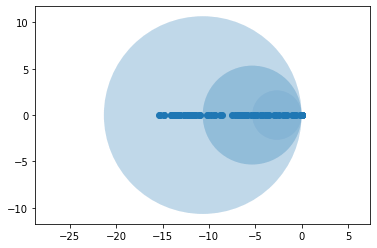

In [12]:
gershgorin(A);

We can see that this isn't a very good estimate of many of the eigenvalues, but it's quite good for the minimal one.

So, if I give you a stencil

$$
\frac{1}{h_x^2}\begin{bmatrix}-1 & 2 & -1\end{bmatrix}
$$

we can immediately say that the maximal eigenvalue will be less than or equal to $\frac{4}{h_x^2}$, and the minimal one will be greater than or equal to zero.

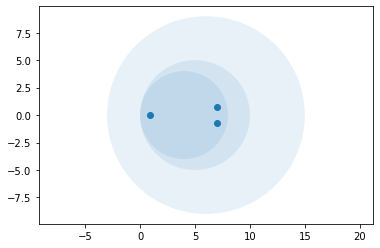

In [13]:
example = np.asarray([[5., 3., 2.], 
                         [4., 6., 5.],
                         [-3., 1., 4.]])
gershgorin(example);

## Breaking through the timestep restriction

Our only chance of being able to take larger timesteps is to increase the size of the stability region. We can try and do so with explicit methods, but we will *always* run into the timestep constraint eventually (since no explicit method contains an unbounded stability region.

Instead, we turn to *implicit* methods. We're now going to have to invert the operator at every timestep, hence our interest in different methods for doing so. We'll do implicit Euler first, for which the discretised problem looks like

$$
\mathbb{I} u^{n+1} - \Delta t \nabla^2 u^{n+1} = u^n.
$$

Rearranging, we obtain

$$
u^{n+1} = (\mathbb{I} - \Delta t \nabla^2)^{-1} u^n
$$

so our update step is to invert an operator onto the old state, rather than applying the operator to the state.

To start with let's use a direct solver:

In [69]:
def implicit_euler(u0, dt, stiffness, T=10):
    A = - stiffness.todense()
    I = np.eye(len(A))
    op = I - dt*A
    lu, piv = scipy.linalg.lu_factor(op)
    t = 0
    us = [u0]
    ts = [t]
    u = u0
    while t < T:
        u = scipy.linalg.lu_solve((lu, piv), u.flat).reshape(u.shape)
        t += dt
        us.append(u)
        ts.append(t)
        if np.linalg.norm(us[-2] - us[-1], np.inf) < 1e-8:
            print("Equilibrium reached at t=", t)
            break
    return ts, us

In [74]:
dt = 2.0
u0 = discretization.setup_initial()
ts, us = implicit_euler(u0, dt, stiffness, T=10)

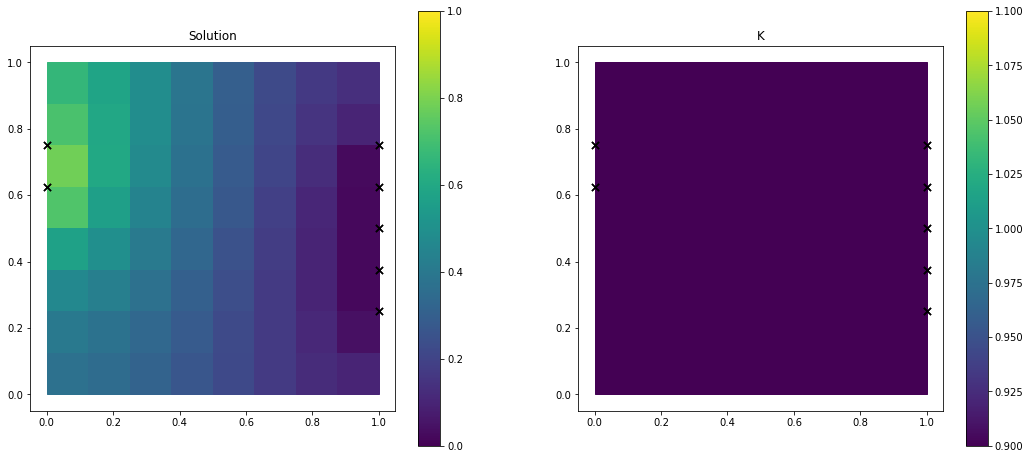

In [75]:
geo.plot_solution(geometry=geometry, discretization=discretization, dirichlet_val=dirichlet_val, sol=us[-1], level=level)

As we have seen in previous lectures, this is not a very efficient method for inverting the matrix. So instead let us apply the multigrid solver we have derived.

We know that the grid does not change, so we can set up all the necessary operators in advance and then simply apply them in each time-step.

Let's set up the components we need starting with a smoother.

In [76]:
def relaxation(A, b, x0, max_iter):
    diagonal_part = sp.diags(A.diagonal())
    diagonal_part_inv = sp.diags(1/A.diagonal())
    rest = A - diagonal_part
    x = x0
    for i in range(max_iter):
        x = diagonal_part_inv @ (b - rest @ x)
    return x

Next we define our interpolation and restriction operators. Again a modification is needed in order to allow non-zero Dirichlet boundary conditions.

In [77]:
def evaluate_solution(geometry, discretization, cell, coord):
    x, y = fem.map_to_reference_coordinates(cell, coord)
    coeff = dict()
    for linear_index, vert in enumerate(cell.vertices):
        if vert not in geometry.dirichlet_vertices:
            coeff[vert] = fem.lagrange_2d(discretization.nodes_x, linear_index, np.array([x,y]))
        else:
            coeff[vert] = dirichlet_val(cell.center, cell.size, cell.size)*fem.lagrange_2d(discretization.nodes_x, linear_index, np.array([x,y]))
    return coeff

def make_interpolation(geometry, level_coarse):
    level_fine = level_coarse + 1
    discretization = fem.Discretization(geometry, level_fine)

    number_of_vertices_coarse = geometry.number_of_vertices_per_level[level_coarse]
    number_of_vertices_fine = geometry.number_of_vertices_per_level[level_fine]
    
    interpolation = sp.lil_matrix((number_of_vertices_fine, number_of_vertices_coarse), dtype=np.float64)
    
    for cell in geometry.grid.dfs(only_level=level_fine):
        for vert in cell.vertices:
            data_idx_fine = geometry.vertex_idx_to_data_idx[vert]
            coords = geometry.vertices_idx_to_coords[vert]
            coeffs = evaluate_solution(geometry, discretization, cell.parent, np.array(coords))
            for key, val in coeffs.items():
                data_idx_coarse = geometry.vertex_idx_to_data_idx[key]
                interpolation[data_idx_fine, data_idx_coarse] = val
    return interpolation.tocsc()

def make_restriction(geometry, level_coarse):
    return make_interpolation(geometry, level_coarse).T

And finally we store all the needed operators. Here, instead of the original stiffness matrix A we want to store $I-dt A$, as needed for the Euler step.

In [78]:
class MultigridStorage:
    def __init__(self, discretization, level_min, level_max, stiffness):
        self.level_min = level_min
        self.level_max = level_max
        
        self.geometry = discretization.geometry
        geometry = discretization.geometry
        
        number_of_levels = (level_max - level_min + 1)
        self.coarse_to_fine = [None] * number_of_levels
        self.fine_to_coarse = [None] * number_of_levels
        self.stiffness = [None] * number_of_levels
        self.stiffness_matrix = [None] * number_of_levels
        self.stiffness_matrix[-1] = stiffness
        self.stiffness[-1] = sp.diags(np.ones(stiffness.shape[0])) + dt*stiffness
  
        for level_index in range(number_of_levels - 1, -1, -1):
            level = level_index + level_min
            self.coarse_to_fine[level_index] = \
                make_interpolation(geometry, level_coarse=level-1)
            self.fine_to_coarse[level_index] = make_restriction(geometry, level_coarse=level-1)
            if level != level_max:
                interpolation = make_interpolation(geometry, level_coarse=level)
                restriction = make_restriction(geometry, level_coarse=level)
                self.stiffness_matrix[level_index] = \
                   restriction * self.stiffness_matrix[level_index+1] * interpolation
                self.stiffness[level_index] = sp.diags(np.ones(self.stiffness_matrix[level_index].shape[0])) + dt*self.stiffness_matrix[level_index]
                discretization_coarse = fem.Discretization(geometry, level=level, eval_k=discretization.eval_k)

storage = MultigridStorage(discretization, level_min=1, level_max=level, stiffness=stiffness)

Now that we have these we can define the v-cycle as before.

In [79]:
def v_cycle(storage, level, rhs, unknowns):
    level_index = level - storage.level_min
    restriction = storage.fine_to_coarse[level_index]
    stiffness = storage.stiffness[level_index]
    unknowns = relaxation(A=stiffness, b=rhs, x0=unknowns, max_iter=5)
    if level != storage.level_min:
        residual_fine = (rhs - stiffness @ unknowns)
        rhs_coarse = restriction @ residual_fine
        unknowns_coarse = np.zeros(storage.geometry.number_of_vertices_per_level[level_index])

        update = v_cycle(storage, level-1, rhs=rhs_coarse, unknowns=unknowns_coarse)
        # Correct
        unknowns += storage.coarse_to_fine[level_index] @ update
    unknowns = relaxation(A=stiffness, b=rhs, x0=unknowns, max_iter=5)
    return unknowns

def compute_residual(A, x, b):
    return np.linalg.norm(A @ x - b)

def multigrid(storage, level, rhs):
    # Zero initial guess
    unknowns = np.zeros(geometry.number_of_vertices_per_level[storage.level_max])
    for cycle in range(100):
        if compute_residual(storage.stiffness[level-1],unknowns,rhs) < 1e-6:
            print("Finished after  multigrid V-cycles.", cycle)
            break
        unknowns = v_cycle(storage, level=storage.level_max, rhs=rhs, unknowns=unknowns) 
    return unknowns

Now instead of using an LU decomposition we can apply the multigrid solver. In each step we solve
$$(I-dt A) u^\text{new} = u^\text{old}.$$
The right hand side is given by the previous solution and the discretised operator has been defined above.

In [80]:
def implicit_euler(u0, dt, stiffness, T=10):
    t = 0
    us = [u0]
    ts = [t]
    u = u0
    while t < T:
        u = multigrid(storage, level=storage.level_max, rhs=u)
        t += dt
        us.append(u)
        ts.append(t)
        if np.linalg.norm(us[-2] - us[-1], np.inf) < 1e-8:
            print("Equilibrium reached at t=",t)
            break
    return ts, us

Finished after  multigrid V-cycles. 8
Finished after  multigrid V-cycles. 9
Finished after  multigrid V-cycles. 9
Finished after  multigrid V-cycles. 9
Finished after  multigrid V-cycles. 10


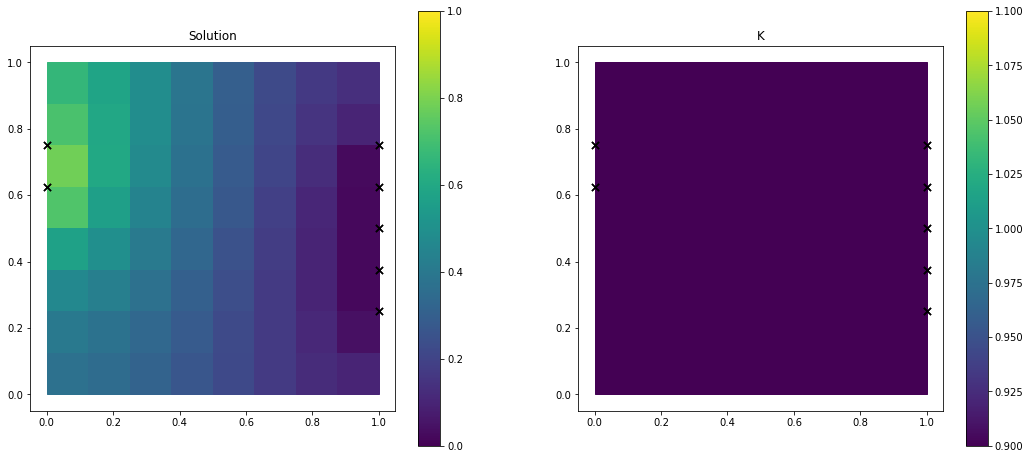

In [82]:
dt = 2.0

u0 = discretization.setup_initial()
ts, us = implicit_euler(u0, dt, stiffness, T=10.0)
geo.plot_solution(geometry=geometry, discretization=discretization, dirichlet_val=dirichlet_val, sol=us[-1], level=level)